In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d, RegularGridInterpolator
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LogNorm
from scipy.integrate import trapz as integrate
from scipy.integrate import cumtrapz as cumintegrate
from functions import interp

from helper import *
import const


In [2]:
elements = SimpleNamespace(**np.load('elements.npz'))

In [3]:
with open('../EPICS/EEDL.txt', 'r') as f:
    lines_all = f.readlines()


In [4]:
code = {
    '23501': 'sig_tot',
    '23522': 'sig_ion',
    '23525': 'sig_scat_la',
    '23526': 'sig_scat',
    '23527': 'sig_brem',
    '23528': 'sig_exc',
    '23534': 'sig_ion_K',
    '23535': 'sig_ion_L1',
    '23536': 'sig_ion_L2',
    '23537': 'sig_ion_L3',
    '23538': 'sig_ion_M1',
    '23539': 'sig_ion_M2',
    '23540': 'sig_ion_M3',
    '23541': 'sig_ion_M4',
    '23542': 'sig_ion_M5',
    '23543': 'sig_ion_N1',
    '23544': 'sig_ion_N2',
    '23545': 'sig_ion_N3',
    '23546': 'sig_ion_N4',
    '23547': 'sig_ion_N5',
    '23548': 'sig_ion_N6',
    '23549': 'sig_ion_N7',
    '23550': 'sig_ion_O1',
    '23551': 'sig_ion_O2',
    '23552': 'sig_ion_O3',
    '23553': 'sig_ion_O4',
    '23554': 'sig_ion_O5',
    '23555': 'sig_ion_O6',
    '23556': 'sig_ion_O7',
    '23559': 'sig_ion_P1',
    '23560': 'sig_ion_P2',
    '23561': 'sig_ion_P3',
    '23562': 'sig_ion_P4',
    '23563': 'sig_ion_P5',
    '23570': 'sig_ion_Q1',
    '26525': 'th_scat',
    '26527': 'spec_brem',
    '26528': 'spec_exc',
    '26534': 'spec_ion_K',
    '26535': 'spec_ion_L1',
    '26536': 'spec_ion_L2',
    '26537': 'spec_ion_L3',
    '26538': 'spec_ion_M1',
    '26539': 'spec_ion_M2',
    '26540': 'spec_ion_M3',
    '26541': 'spec_ion_M4',
    '26542': 'spec_ion_M5',
    '26543': 'spec_ion_N1',
    '26544': 'spec_ion_N2',
    '26545': 'spec_ion_N3',
    '26546': 'spec_ion_N4',
    '26547': 'spec_ion_N5',
    '26548': 'spec_ion_N6',
    '26549': 'spec_ion_N7',
    '26550': 'spec_ion_O1',
    '26551': 'spec_ion_O2',
    '26552': 'spec_ion_O3',
    '26553': 'spec_ion_O4',
    '26554': 'spec_ion_O5',
    '26555': 'spec_ion_O6',
    '26556': 'spec_ion_O7',
    '26559': 'spec_ion_P1',
    '26560': 'spec_ion_P2',
    '26561': 'spec_ion_P3',
    '26562': 'spec_ion_P4',
    '26563': 'spec_ion_P5',
    '26570': 'spec_ion_Q1'
}


In [5]:
nelem = 99
ndtype = len(code)


In [15]:
lines_sorted = np.empty((nelem, ndtype), dtype=object)
for i in range(nelem):
    for j in range(ndtype):
        lines_sorted[i, j] = []

for line in lines_all:
     
    if line[66:68] == '  ': continue
    if line[70:75] not in code.keys(): continue
    
    Zelem = int(line[66:68])
    dtype_idx = list(code.keys()).index(line[70:75])
    line_data = [line[0:11], line[11:22], line[22:33], line[33:44], line[44:55], line[55:66]]
    line_data = np.array([float(val) if val != '           ' else np.nan for val in line_data])
    lines_sorted[Zelem-1, dtype_idx].append(line_data)
    
for i in range(nelem):
    for j in range(ndtype):
        lines_sorted[i, j] = np.array(lines_sorted[i, j])
        

In [54]:
data_all = np.empty((nelem, ndtype), dtype=object)

for i in range(nelem):
    for j in range(ndtype):
        
        lines = lines_sorted[i, j]
        dtype_name = list(code.values())[j]
        if lines.size == 0: continue
        
        if dtype_name[:3] == 'sig':
            
            ener, sig = lines[3:].flatten().reshape(-1, 2).T
            ener, sig = ener[~np.isnan(ener)][1:], sig[~np.isnan(sig)][1:]
            sig = sig*const.ba
            
            data = (np.array(ener), np.array(sig))
            if dtype_name[:7] == 'sig_ion' and len(dtype_name) > 7: 
                ener_bind = lines[1, 0]
                data += (ener_bind,)
            
        if dtype_name == 'th_scat':
            
            idx_line_new_ener = np.argwhere(lines[8:, 0]==0).flatten()
            ener_list = lines[8:, 1][idx_line_new_ener]
            data = np.empty(ener_list.size, dtype=object)

            for k, ener in enumerate(ener_list):

                idx_line_min = idx_line_new_ener[k]+1
                idx_line_max = idx_line_new_ener[k+1] if k<ener_list.size-1 else -1
                cos_th_scat, cos_th_pdf = lines[8:, :][idx_line_min:idx_line_max].flatten().reshape(-1, 2).T
                cos_th_scat, cos_th_pdf = cos_th_scat[~np.isnan(cos_th_scat)], cos_th_pdf[~np.isnan(cos_th_pdf)]
                data[k] = (ener, np.array(cos_th_scat), np.array(cos_th_pdf))
                
        if dtype_name == 'spec_exc':
            
            ener, ener_loss = lines[6:].flatten().reshape(-1, 2).T
            ener, ener_loss = ener[~np.isnan(ener)], ener_loss[~np.isnan(ener_loss)]
            data = (np.array(ener), np.array(ener_loss))
            
        if dtype_name == 'spec_brem':
            
            idx_line_elec = np.argwhere(lines[6:, 0]==0).flatten()[-1]+8
            ener, ener_loss = lines[idx_line_elec:].flatten().reshape(-1, 2).T
            ener, ener_loss = ener[~np.isnan(ener)], ener_loss[~np.isnan(ener_loss)]
            data = (np.array(ener), np.array(ener_loss))
            
        if dtype_name[:8] == 'spec_ion':
            
            idx_line_new_ener = np.argwhere(lines[6:, 0]==0).flatten()
            ener_list = lines[6:, 1][idx_line_new_ener]
            data = np.empty(ener_list.size, dtype=object)

            for k, ener in enumerate(ener_list):

                idx_line_min = idx_line_new_ener[k]+1
                idx_line_max = idx_line_new_ener[k+1] if k<ener_list.size-1 else -1
                ener_loss, ener_loss_pdf = lines[6:, :][idx_line_min:idx_line_max].flatten().reshape(-1, 2).T
                ener_loss, ener_loss_pdf = ener_loss[~np.isnan(ener_loss)] + ener_bind, ener_loss_pdf[~np.isnan(ener_loss_pdf)]
                data[k] = (ener, np.array(ener_loss), np.array(ener_loss_pdf))
        
        data_all[i, j] = data
            

In [55]:
np.savez('EEDL', dtype_list=np.array(list(code.values())), data=data_all)


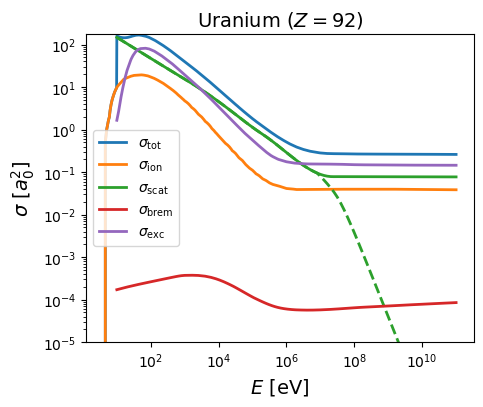

In [20]:
Zelem = 92

fig, ax = plt.subplots(figsize=(5, 4))

sig_name_list = ['sig_tot', 'sig_ion', 'sig_scat_la', 'sig_scat', 'sig_brem', 'sig_exc']
label_list = [r'$\sigma_{\rm tot}$', r'$\sigma_{\rm ion}$', None, r'$\sigma_{\rm scat}$', r'$\sigma_{\rm brem}$', r'$\sigma_{\rm exc}$']
color_list = ['C0', 'C1', 'C2', 'C2', 'C3', 'C4']
linestyle_list = ['-', '-', '--', '-', '-', '-']

for i, sig_name in enumerate(sig_name_list):

    dtype_idx = list(code.values()).index(sig_name)
    ener, sig = data_all[Zelem-1, dtype_idx]
    ax.plot(ener, sig/const.a0**2, label=label_list[i], color=color_list[i], linestyle=linestyle_list[i], lw=2)

ax.set_ylim(1e-5)
    
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$E$ [eV]', fontsize=14)
ax.set_ylabel(r'$\sigma$ [$a_0^2$]', fontsize=14)
ax.set_title('%s ($Z=%d$)' % (elements.name[Zelem-1], Zelem), fontsize=14)

ax.legend()


Saved figure as 'Mg_ionized_comp-061820240924.png'


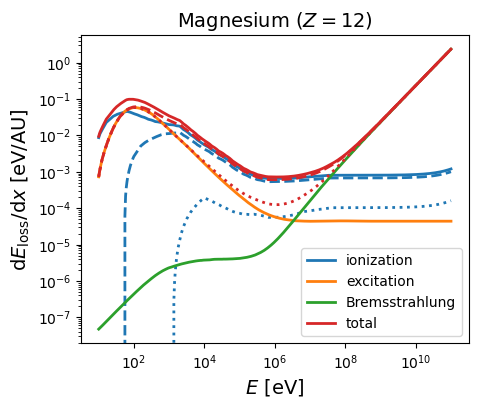

In [53]:
Zelem = 12
n = 1

fig, ax = plt.subplots(figsize=(5, 4))

ener_reg = np.logspace(1, 11, 512)
ener_loss_ion_reg = np.zeros_like(ener_reg)
ener_loss_ion_reg_2 = np.zeros_like(ener_reg)
ener_loss_ion_reg_3 = np.zeros_like(ener_reg)

sig_name_list = []
sig_list = []

for i in range(ndtype):
    
    dtype_name = list(code.values())[i]
    if dtype_name[:7] != 'sig_ion' or len(dtype_name)==7: continue
        
    data = data_all[Zelem-1, i]
    if type(data) == type(None): continue
        
    ener, sig, ener_bind = data
    sig_reg = interp(ener_reg, ener, sig, llim=0)
    sig_reg[ener_reg<ener_bind] = 0
    
    sig_name_list.append(dtype_name)
    sig_list.append(sig_reg)

for i in range(ndtype):
    
    dtype_name = list(code.values())[i]
    if dtype_name[:8] != 'spec_ion': continue

    data = data_all[Zelem-1, i]
    if np.all(data) == None: continue

    ener_list = np.array([data_ener[0] for data_ener in data])
    ener_loss_avg = np.zeros_like(ener_list)

    for j, data_ener in enumerate(data):

        ener, ener_loss, ener_loss_pdf = data_ener
        ener_loss_avg[j] = integrate(ener_loss_pdf*ener_loss, ener_loss)/integrate(ener_loss_pdf, ener_loss)
    
    ener_loss_avg_reg = interp(ener_reg, ener_list, ener_loss_avg)
    ener_loss_avg_reg[ener_reg<ener_bind] = 0
    
    sig_reg = sig_list[sig_name_list.index('sig_%s'%dtype_name[5:])]
    ener_loss_ion_reg += ener_loss_avg_reg*sig_reg/n
    if dtype_name != 'spec_ion_M1': ener_loss_ion_reg_2 += ener_loss_avg_reg*sig_reg*n
    if dtype_name not in ['spec_ion_M1', 'spec_ion_L1', 'spec_ion_L2', 'spec_ion_L3']: ener_loss_ion_reg_3 += ener_loss_avg_reg*sig_reg*n

idx_dtype = list(code.values()).index('sig_exc')
ener, sig = data_all[Zelem-1, idx_dtype]
sig_reg = interp(ener_reg, ener, sig, llim=0)

idx_dtype = list(code.values()).index('spec_exc')
ener, ener_loss = data_all[Zelem-1, idx_dtype]
ener_loss_exc_reg = interp(ener_reg, ener, ener_loss)*sig_reg*n

idx_dtype = list(code.values()).index('sig_brem')
ener, sig = data_all[Zelem-1, idx_dtype]
sig_reg = interp(ener_reg, ener, sig, llim=0)

idx_dtype = list(code.values()).index('spec_brem')
ener, ener_loss = data_all[Zelem-1, idx_dtype]
ener_loss_brem_reg = interp(ener_reg, ener, ener_loss)*sig_reg*n

ener_loss_tot_reg = ener_loss_ion_reg + ener_loss_exc_reg + ener_loss_brem_reg
ener_loss_tot_reg_2 = ener_loss_ion_reg_2 + ener_loss_exc_reg + ener_loss_brem_reg
ener_loss_tot_reg_3 = ener_loss_ion_reg_3 + ener_loss_exc_reg + ener_loss_brem_reg

ax.plot(ener_reg, ener_loss_ion_reg/(1/const.AU), lw=2, label='ionization', color='C0')
ax.plot(ener_reg, ener_loss_ion_reg_2/(1/const.AU), lw=2, color='C0', linestyle='--')
ax.plot(ener_reg, ener_loss_ion_reg_3/(1/const.AU), lw=2, color='C0', linestyle=':')
ax.plot(ener_reg, ener_loss_exc_reg/(1/const.AU), lw=2, label='excitation', color='C1')
ax.plot(ener_reg, ener_loss_brem_reg/(1/const.AU), lw=2, label='Bremsstrahlung', color='C2')
ax.plot(ener_reg, ener_loss_tot_reg/(1/const.AU), lw=2, label='total', color='C3')
ax.plot(ener_reg, ener_loss_tot_reg_2/(1/const.AU), lw=2, color='C3', linestyle='--')
ax.plot(ener_reg, ener_loss_tot_reg_3/(1/const.AU), lw=2, color='C3', linestyle=':')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$E$ [eV]', fontsize=14)
ax.set_ylabel(r'${\rm d}E_{\rm loss}/{\rm d}x$ [eV/AU]', fontsize=14)
ax.set_title('%s ($Z=%d$)' % (elements.name[Zelem-1], Zelem), fontsize=14)

ax.legend()

save_fig('Mg_ionized_comp')
    

Text(0.5, 1.0, 'Tellurium ($Z=52$)')

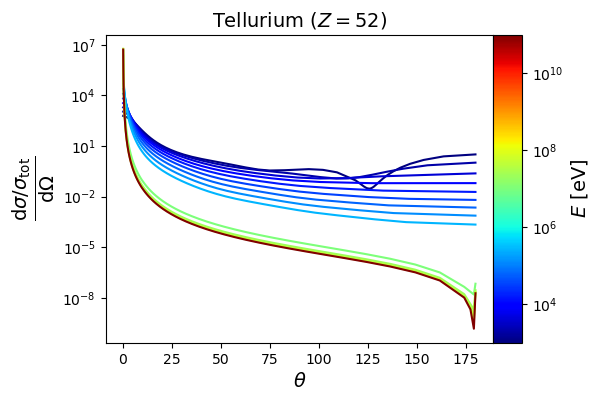

In [10]:
Zelem = 52

fig, ax = plt.subplots(figsize=(5, 4))

idx_dtype = list(code.values()).index('th_scat')
data = data_all[Zelem-1, idx_dtype]
ener_list = np.array([data_ener[0] for data_ener in data])
norm = LogNorm(1e3, 1e11)

cmap = mpl.colormaps['jet']
color_list = cmap(norm(ener_list))

for i, data_ener in enumerate(data):
    
    ener, cos_th_scat, cos_th_pdf = data_ener
    ax.plot(np.arccos(cos_th_scat)*180/np.pi, 2*np.pi*cos_th_pdf, color=color_list[i])
    
ax.set_yscale('log')

sm = ScalarMappable(LogNorm(1e3, 1e11), cmap=cmap)

cax = ax.inset_axes([1, 0, 0.075, 1])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label(r'$E$ [${\rm eV}$]', fontsize=14)

ax.set_xlabel(r'$\theta$', fontsize=14)
ax.set_ylabel(r'$\frac{{\rm d}\sigma/\sigma_{\rm tot}}{{\rm d}\Omega}$', fontsize=20)
ax.set_title('%s ($Z=%d$)' % (elements.name[Zelem-1], Zelem), fontsize=14)


Text(0.5, 1.0, 'Uranium ($Z=92$)')

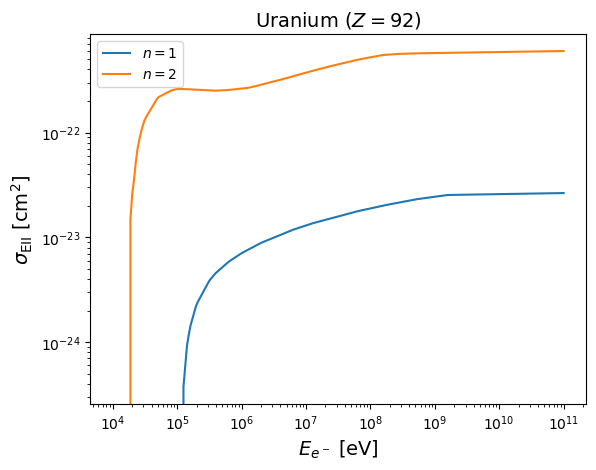

In [411]:
Zelem = 92

num = 256
ener0_list = np.logspace(4, 11, num)
idx_list = [list(code.values()).index(dtype) for dtype in ['sig_ion_K', 'sig_ion_L1', 'sig_ion_L2', 'sig_ion_L3']]
sig_list = np.zeros((len(idx_list), num))

for i, idx in enumerate(idx_list):

    data = data_all[Zelem-1, idx]
    ener, sig, ener_bind = data
    
    for j, ener0 in enumerate(ener0_list):
        
        sig_list[i, j] = interp(ener0, ener, sig, logx=True, logy=True)

plt.plot(ener0_list, sig_list[0], label=r'$n=1$')
plt.plot(ener0_list, np.sum(sig_list[1:], axis=0), label=r'$n=2$')

plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.xlabel(r'$E_{e^-}$ [${\rm eV}$]', fontsize=14)
plt.ylabel(r'$\sigma_{\rm EII}$ [${\rm cm^2}$]', fontsize=14)
plt.title(r'%s ($Z=%d$)' % (elements.name[Zelem-1], Zelem), fontsize=14)
        
# save_fig('sig_EII')
    

Text(0.5, 1.0, '$3s_{1/2}$ subshell, $E_{e^-} = 1~{\\rm MeV}$')

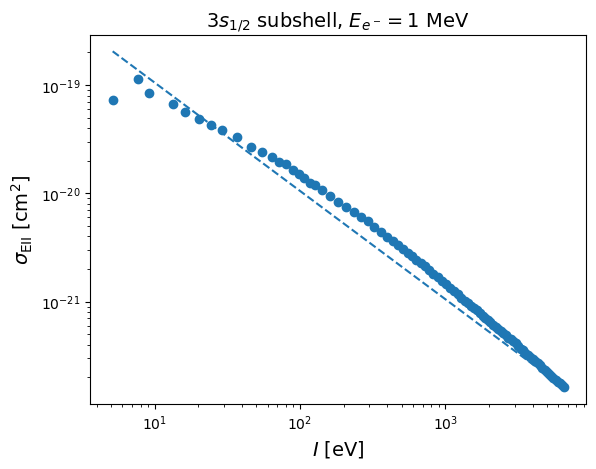

In [412]:
ener0 = 1000000

Zelem_list = range(11, 98)
idx = list(code.values()).index('sig_ion_M1')

ener_bind_list = []
sig_list = []

for Zelem in Zelem_list:
    
    data = data_all[Zelem-1, idx]
    ener, sig, ener_bind = data
    sig_i = interp(ener0, ener, sig, logx=True, logy=True)
    
    ener_bind_list.append(ener_bind)
    sig_list.append(sig_i)
    
ener_bind_list, sig_list = np.array(ener_bind_list), np.array(sig_list)
    
plt.loglog(ener_bind_list, sig_list, lw=2, marker='o', linestyle='')

ener_bind_s = np.logspace(np.log10(ener_bind_list[0]), np.log10(ener_bind_list[-1]), 256)
plt.plot(ener_bind_s, sig_list[-1]*(ener_bind_list[-1]/ener_bind_s)**1, color='C0', linestyle='--')

plt.xlabel(r'$I$ [${\rm eV}$]', fontsize=14)
plt.ylabel(r'$\sigma_{\rm EII}$ [${\rm cm^2}$]', fontsize=14)
plt.title(r'$3s_{1/2}$ subshell, $E_{e^-} = 1~{\rm MeV}$', fontsize=14)

# save_fig('sig_EII')


In [93]:
from sim import calc_sig_Bturb

time = 10*const.day
rproc = 'strong'
run = 1
ener = 1000000

data_rproc = np.load(os.path.join('..', 'rprocess', '%s.npz' % rproc), allow_pickle=True)
data_rproc = SimpleNamespace(**data_rproc)
idx_rproc = np.searchsorted(data_rproc.time, time)
ab = data_rproc.ab_elem[idx_rproc]
A_avg = data_rproc.A_avg[idx_rproc]
mu = np.sum(ab*A_avg)

sig = 0
data_EEDL = SimpleNamespace(**np.load('EEDL.npz', allow_pickle=True))
for i, (ener_i, sig_i) in enumerate(data_EEDL.data[:, 0]):
    if ab[i+1]>0:
        sig += interp(ener, ener_i, sig_i, logx=True, logy=True)*ab[i+1]/A_avg[i+1]

rho = np.logspace(-16, -11, 512)
Bmag = np.logspace(-4, 5, 512)
rho, Bmag = np.meshgrid(rho, Bmag)
fturb = 1
sig_Bturb = calc_sig_Bturb(Bmag, fturb, ener, rho, const.m_e, const.e, q=1.9, Lmax=1e17)

data_KNe = np.load(os.path.join('..', 'KNexplosions', 'runhr%d.npz' % run))
data_KNe = SimpleNamespace(**data_KNe)

rho_shock = data_KNe.rho_shock
temp_shock = data_KNe.temp_shock
n_shock = rho_shock*const.N_A/mu
Bmag_shock_beta1e0 = np.sqrt(4*np.pi*n_shock*const.k_B*temp_shock)
Bmag_shock_beta1em2 = Bmag_shock_beta1e0*np.sqrt(0.01)


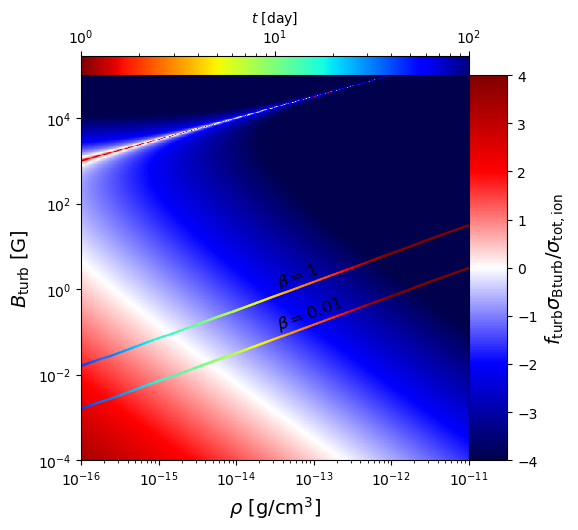

In [94]:
fig, ax = plt.subplots(figsize=(5, 5))

im = ax.pcolormesh(rho, Bmag, np.log10(sig_Bturb/sig), cmap='seismic', vmin=-4, vmax=4)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$\rho$ [${\rm g/cm^3}$]', fontsize=14)
ax.set_ylabel(r'$B_{\rm turb}$ [${\rm G}$]', fontsize=14)

cax = ax.inset_axes([1, 0, 0.1, 1])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(r'$f_{\rm turb} \sigma_{\rm Bturb}/\sigma_{\rm tot,ion}$', fontsize=14)

ax.set_xlim(1e-16, 1e-11)
ax.set_ylim(1e-4, 1e5)

cmap = mpl.colormaps['jet_r']
norm = LogNorm(1, 100)
sm = ScalarMappable(norm, cmap=cmap)
color_list = cmap(norm(data_KNe.time/const.day))

for i in range(data_KNe.time.size-1):
    ax.plot(rho_shock[i:i+2], Bmag_shock_beta1e0[i:i+2], color=color_list[i])
    ax.plot(rho_shock[i:i+2], Bmag_shock_beta1em2[i:i+2], color=color_list[i])

ax.annotate(r'$\beta=1$', (0.5, 0.45), xycoords='axes fraction', fontsize=12, rotation=20)
ax.annotate(r'$\beta=0.01$', (0.5, 0.34), xycoords='axes fraction', fontsize=12, rotation=20)
    
cax = ax.inset_axes([0, 1, 1, 0.05])
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label(r'$t$ [${\rm day}$]')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')

# save_fig('sig_comp')
    

In [86]:
ener = 1000000
rho = 1e-15
temp = 1e4

ener0 = const.m_e*const.c**2
ener_tot = ener0 + ener*const.eV
pmag = np.sqrt(ener_tot**2 - ener0**2)/const.c

sin_th_cm = np.logspace(np.log10(1e-8), 0, 2**15)[::-1]
cos_th_cm = np.sqrt(1-sin_th_cm**2)
ener_loss = ener/2*(1-cos_th_cm)

ener_tot_cm = np.sqrt(ener0/2 * (2*ener0 + ener*const.eV))
pmag_cm = np.sqrt(ener_tot_cm**2 - ener0**2)/const.c

fac1 = (ener_tot_cm**2-const.m_e**2*const.c**4)**2
fac2 = (8*ener_tot_cm**4 - 4*const.m_e**2*const.c**4*ener_tot_cm**2 - const.m_e**4*const.c**8) / fac1
fac3 = 4*(2*ener_tot_cm**2 - const.m_e**2*const.c**4)**2 / fac1
fac4 = const.alpha**2*const.hbar**2*const.c**2/(4*ener_tot_cm**2)
sig_pdf = 4*np.pi*fac4*(1 - fac2/sin_th_cm**2 + fac3/sin_th_cm**4 )
sig_cdf = 4*np.pi*fac4*(1-sin_th_cm + fac2*(1-1/sin_th_cm) - fac3/3*(1-1/sin_th_cm**3) )

bmax = np.sqrt(const.k_B*temp/(4*np.pi*rho*const.N_A*const.e**2))
bmin = const.h/pmag_cm

sin_th_cm_max = interp(bmin**2/np.pi, sig_cdf, sin_th_cm, logx=True, logy=True)
sin_th_cm_min = interp(bmax**2/np.pi, sig_cdf, sin_th_cm, logx=True, logy=True)

cos_th_cm_min = np.sqrt(1-sin_th_cm_max**2)
cos_th_cm_max = np.sqrt(1-sin_th_cm_min**2)

th_max = np.arccos(np.sqrt((2*const.m_e*const.c**2+ener*const.eV)*(1+cos_th_cm_min)/(4*const.m_e*const.c**2+ener*const.eV*(1+cos_th_cm_min))))
th_min = np.arccos(np.sqrt((2*const.m_e*const.c**2+ener*const.eV)*(1+cos_th_cm_max)/(4*const.m_e*const.c**2+ener*const.eV*(1+cos_th_cm_max))))

th_min*180/np.pi, th_max*180/np.pi


(3.818191820832846e-06, 0.8775300954519504)

In [87]:
bmax

0.028120958477021354

In [81]:
sig = 4*np.pi*fac4*(sin_th_cm_max-sin_th_cm_min + fac2*(1/sin_th_cm_max-1/sin_th_cm_min) - fac3/3*(1/sin_th_cm_max**3-1/sin_th_cm_min**3) )

sig


0.0002517157355721315

In [253]:
idx_max = sin_th_cm.size-np.searchsorted(sin_th_cm[::-1], sin_th_cm_max)
idx_min = sin_th_cm.size-np.searchsorted(sin_th_cm[::-1], sin_th_cm_min)

-integrate((sig_pdf*ener_loss/sig)[idx_max:idx_min], sin_th_cm[idx_max:idx_min])


1.161845189835616e-07

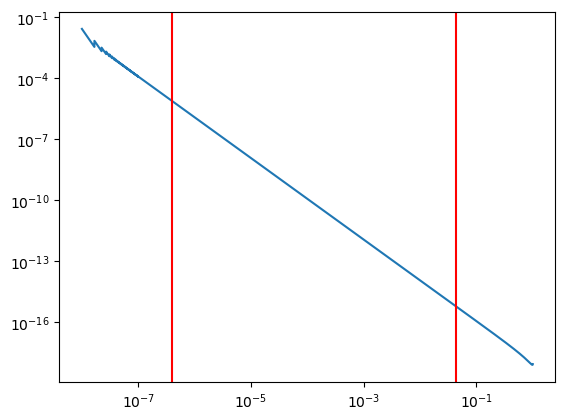

In [251]:
plt.loglog(sin_th_cm, ener_loss*sig_pdf)
plt.axvline(x=sin_th_cm_min, color='red')
plt.axvline(x=sin_th_cm_max, color='red')


In [377]:
def calc_moller(xi, ener, bmin, bmax, num=2048):
    ''' 
    Compute the cross section, energy loss, and scattering angle in a Moller (electron-electron) scattering event.
    
    Args
    xi:       random number
    ener:     kinetic energy [eV]
    frac_lim: relative kinetic energy loss below which we ignore Moller scattering
    num:      number of points to sample the CDF

    Returns
    sig:       cross section [1/cm^2]
    cos_th:    scattering angle
    ener_loss: energy loss [eV]
    '''        
    sin_th_cm = np.logspace(np.log10(1e-8), 0, num)[::-1]

    ener_tot_cm = np.sqrt(const.m_e*const.c**2/2 * (2*const.m_e*const.c**2 + ener*const.eV))
    fac1 = (ener_tot_cm**2-const.m_e**2*const.c**4)**2
    fac2 = (8*ener_tot_cm**4 - 4*const.m_e**2*const.c**4*ener_tot_cm**2 - const.m_e**4*const.c**8) / fac1
    fac3 = 4*(2*ener_tot_cm**2 - const.m_e**2*const.c**4)**2 / fac1
    fac4 = const.alpha**2*const.hbar**2*const.c**2/(4*ener_tot_cm**2)
    dsigdnu_cum = 4*np.pi*fac4*(1-sin_th_cm + fac2*(1-1/sin_th_cm) - fac3/3*(1-1/sin_th_cm**3))
     
    sin_th_cm_max = interp(bmin**2/np.pi, dsigdnu_cum, sin_th_cm, logx=True, logy=True)
    sin_th_cm_min = interp(bmax**2/np.pi, dsigdnu_cum, sin_th_cm, logx=True, logy=True)
    
    sig = 4*np.pi*fac4*(sin_th_cm_max-sin_th_cm_min + fac2*(1/sin_th_cm_max-1/sin_th_cm_min) - fac3/3*(1/sin_th_cm_max**3-1/sin_th_cm_min**3) )
    sig_cdf = dsigdnu_cum/sig

    sin_th_cm = interp(xi, sig_cdf, sin_th_cm, logx=True, logy=True)
    cos_th_cm = np.sqrt(1-sin_th_cm**2)
    ener_loss = ener/2*(1-cos_th_cm)
    cos_th = np.sqrt((2*const.m_e*const.c**2+ener*const.eV)*(1+cos_th_cm)/(4*const.m_e*const.c**2+ener*const.eV*(1+cos_th_cm)))

    return sig, cos_th, ener_loss


In [390]:
ener = 1000000
rho = 1e-14
temp = 1e4

ener_tot_cm = np.sqrt(ener0/2 * (2*ener0 + ener*const.eV))
pmag_cm = np.sqrt(ener_tot_cm**2 - ener0**2)/const.c
bmax = np.sqrt(const.k_B*temp/(4*np.pi*rho*const.N_A*const.e**2))
bmin = const.h/pmag_cm

sig, cos_th, ener_loss = calc_moller(np.random.random(), ener, bmin, 1e-3)

print(sig)
print(np.arccos(cos_th)*180/np.pi)
print(ener_loss)


3.183098861837723e-07
5.3970381121306227e-05
1.7554291353860663e-06


In [544]:
temp = 3e4

data_EEDL = SimpleNamespace(**np.load('EEDL.npz', allow_pickle=True))

nelem = 98
nshell = 29
g = np.zeros((nelem, nshell))
ener_bind = np.zeros((nelem, nshell))

term_sym = SimpleNamespace(
    s=np.array([1/2, 1/2, 3/2, 3/2, 5/2, 5/2, 7/2]),
    l=np.array([0, 1, 1, 2, 2, 3, 3])
)
term_sym.g = (2*term_sym.s+1) * (2*term_sym.l+1)
term_sym.mult = (term_sym.s+0.5).astype(int)

n=0
for Zelem in range(1, 99):
    
    g_list = [1]
    ener_bind_list = []
    
    idx_ion = 0
    for i, dtype_name in enumerate(data_EEDL.dtype_list):
        if dtype_name[:7] != 'sig_ion' or len(dtype_name) == 7: continue
        if data_EEDL.data[Zelem-1, i]:
            
            ener, sig, ener_bind = data_EEDL.data[Zelem-1, i]
            idx_term_sym = 0 if dtype_name == 'sig_ion_K' else int(dtype_name[-1:])-1
            g_list += term_sym.mult[idx_term_sym]*[term_sym.g[idx_term_sym]]
            ener_bind_list += term_sym.mult[idx_term_sym]*[ener_bind]

        idx_ion += 1


## This is wrong!!!

In [543]:
g_li
g_list, ener_bind_list = np.array(g_list), np.array(ener_bind_list)

g_list[1:]/g_list[:-1] * np.exp(-ener_bind_list)


array([1.        , 3.        , 2.        , 1.        , 0.16666667,
       3.        , 2.        , 1.        , 1.66666667, 1.        ,
       1.5       , 1.        , 1.        , 0.06666667, 3.        ,
       2.        , 1.        , 1.66666667, 1.        , 1.5       ,
       1.        , 1.        , 1.4       , 1.        , 1.        ,
       1.33333333, 1.        , 1.        , 1.        , 0.03571429,
       3.        , 2.        , 1.        , 1.66666667, 1.        ,
       1.5       , 1.        , 1.        , 1.4       , 1.        ,
       1.        , 1.33333333, 1.        , 1.        , 1.        ,
       0.03571429, 3.        , 2.        , 1.        , 0.16666667])